# Hovmoller Temperature Depth

This notebook shows how to calculate a depth-time Hovmoller plot of 30-year anomalies of globally averaged of conservative temperature, practical salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cosima_cookbook as cc
from matplotlib.gridspec import GridSpec
import cmocean.cm as cm
import xarray as xr
from dask.distributed import Client
import IPython.display
import matplotlib.dates as mdates
from matplotlib import ticker

In [49]:
client = Client(n_workers = 4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33181/status,
Dashboard: /proxy/33181/status,Workers: 4
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40277,Workers: 4
Dashboard: /proxy/33181/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:34915,Total threads: 7
Dashboard: /proxy/35939/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:44059,


In [50]:
## Opening the cosima cookbook session
session = cc.database.create_session()
expt1deg = '1deg_jra55_iaf_omip2_cycle6'  # 1-deg experiment
start_time, end_time = '1989-01-01', '2018-12-31'

In [51]:
def load_var(experiment, var, freq, start_time, end_time):
    var_load = cc.querying.getvar(experiment, var, session, frequency = freq, 
                                  start_time=start_time, end_time=end_time)
    var_load.sel(time=slice(start_time, end_time))
    if var == 'temp':
        return var_load - 273.15
    else:
        return var_load
    

In [52]:
## Loading the variables
temp_1deg = load_var(expt1deg, 'temp', '1 monthly', start_time, end_time)
salt_1deg = load_var(expt1deg, 'salt', '1 monthly', start_time, end_time)
IPython.display.clear_output()

In [53]:
temp_anomaly_1deg = temp_1deg - temp_1deg.mean('time') # Computing the anomaly relative to the 30year time average
salt_anomaly_1deg = salt_1deg - salt_1deg.mean('time') # Computing the anomaly relative to the 30year time average

Next, we load cell area (denoted $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$


In [55]:
## Loading the dxt and dyt to estimate the area
dxt_1deg = cc.querying.getvar(expt1deg, 'dxt', session, frequency='static', n = 1)
dyt_1deg = cc.querying.getvar(expt1deg, 'dyt', session, frequency='static', n = 1)
area_1deg = dxt_1deg*dyt_1deg

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [56]:
### Temperature hovmoller
temp_hov_1deg = ((area_1deg*temp_anomaly_1deg).sum('xt_ocean').sum('yt_ocean'))/area_1deg.sum('xt_ocean').sum('yt_ocean')
temp_hov_1deg = temp_hov_1deg.compute()

### Salinity hovmoller
salt_hov_1deg = ((area_1deg*salt_anomaly_1deg).sum('xt_ocean').sum('yt_ocean'))/area_1deg.sum('xt_ocean').sum('yt_ocean')
salt_hov_1deg = salt_hov_1deg.compute()

IPython.display.clear_output()

In [57]:
myFmt = mdates.DateFormatter('%Y')
def plot_hov(fsize = 14, date_format = myFmt):
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = fsize
    plt.rcParams['ytick.labelsize'] = fsize
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    fig = plt.figure(figsize = (10,6))
    grd = GridSpec(100,100)
    
    ax = [fig.add_subplot(grd[:30,:30]), fig.add_subplot(grd[:30,33:63]),
          fig.add_subplot(grd[32:,:30]), fig.add_subplot(grd[32:,33:63])]
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 
    
    return fig, ax

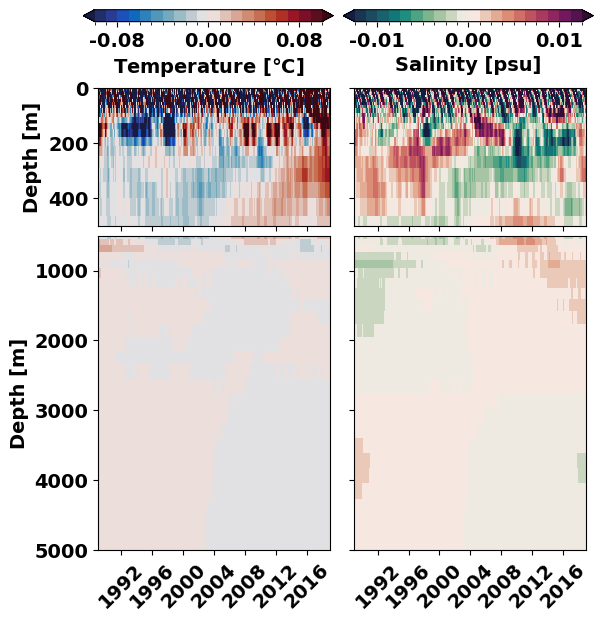

In [58]:
fig, ax = plot_hov(fsize = 14)
lv_temp = np.arange(-.1,.11,.01)
lv_salt = np.arange(-.01,.011,.001)

cf_temp = temp_hov_1deg.plot(ax = ax[0], levels = lv_temp, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')
temp_hov_1deg.plot(ax = ax[2], levels = lv_temp, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')

cf_salt = salt_hov_1deg.plot(ax = ax[1], levels = lv_salt, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')
salt_hov_1deg.plot(ax = ax[3], levels = lv_salt, x = 'time',  y = 'st_ocean', add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')

## Details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500,0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylim(5000,500)
ax[0].set_ylabel("Depth [m]")
ax[2].set_ylabel("Depth [m]")
ax[1].set_ylabel('')
ax[3].set_ylabel('')

# Colorbar
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label('Temperature [$\degree$C]')

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label('Salinity [psu]')

cbar = [cbar_1, cbar_2]
for i in range(len(cbar)):
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar[i].locator = tick_locator
    cbar[i].update_ticks()

# The lines above were written by Felipe in July 2024
#### Andy Hogg suggested to update the code below to the latest version of the cookbook and make it a documented example.
# The lines below were written by Angus in Oct 2018

This notebook shows how to calculate a depth-time Hovmoller plot of globally averaged potential temperature from ACCESS-OM2.

First, the preliminaries, including starting a cluster of 8 workers to do the calculation.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import IPython.display

cc.start_cluster()

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 37545:127.0.0.1:37545 vdi-n22.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:35328 Dashboard: http://127.0.0.1:37545,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**Select an Experiment:**

In [2]:
expt = '1deg_jra55_ryf8485_gfdl50'
#expt= '025deg_jra55v13_ryf8485_spinup_A'

Now, we load an entire temperature dataset, along with the corresponding WOA13 temperature dataset to compute the temperature anomaly.

In [3]:
temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, 
                        time_units="days since 1700-01-01")
temp_WOA13 = cc.get_nc_variable('woa13/10', 'woa13_ts_??_mom10.nc', 'temp').mean('time').compute()
#temp_WOA13 = cc.get_nc_variable('woa13/025', 'woa13_ts_??_mom025.nc', 'temp').mean('time').compute()
temp_anom = temp - temp_WOA13.values - 273.15
IPython.display.clear_output()

Next, we load cell area (denoted $a(x,y,z)$) from the ocean_grid file, construct a mask from the temperature file and make a profile of the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$
*Note that this mask ignores the presence of partial cells, for now*.

In [4]:
area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1).mean('time')
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum('xt_ocean').sum('yt_ocean')
IPython.display.clear_output()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \theta(x,y,z,t)}{A(z)}$$
where $T$ is the average temperature and $\theta$ the potential temperature.

In [5]:
var =area_t*temp_anom
temp_hov = var.sum('xt_ocean').sum('yt_ocean').compute()
temp_hov = temp_hov/area_sum

We can use xarray for a quick and dirty plot of this data:

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


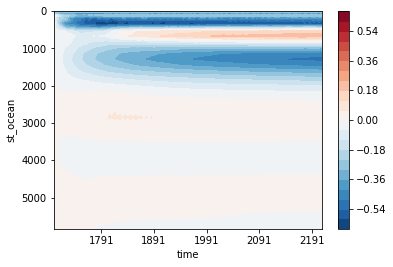

In [6]:
temp_hov.T.plot.contourf(levels=25,yincrease=False)

Alternatively, we could put a little more effort into plotting, including expansion of the upper 1000m:

Text(0.5,1,'Horizontally averaged evolution of potential temperature')

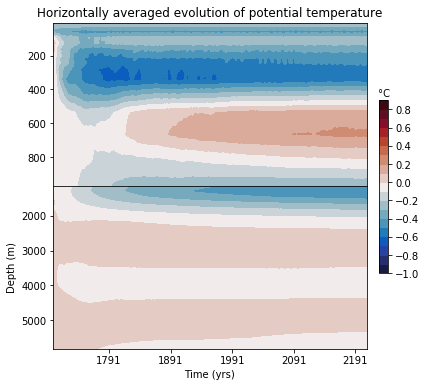

In [7]:
t_up = temp_hov.sel(st_ocean=slice(0,1000))
levs = np.arange(-1,1,0.1)
fig,ax = plt.subplots(2,1,sharex=True,figsize=(6,6))
plt.subplots_adjust(hspace=0,right=0.85)

t_up.T.plot.contourf(ax=ax[0],levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
ax[0].set_ylabel('')

t_lo = temp_hov.sel(st_ocean=slice(1000,6000))
p1=t_lo.T.plot.contourf(ax=ax[1],levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
plt.ylabel('Depth (m)')
plt.xlabel('Time (yrs)')

ax1 = plt.axes([0.88,0.3,0.02,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('°C')

ax[0].set_title('Horizontally averaged evolution of potential temperature')
